## Data Preprocessing

In [79]:
import nltk
import pandas as pd
import numpy as np


In [ ]:
nltk.download('all')

In [84]:
dataset = pd.read_csv('dataset.csv')

In [85]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [86]:
ps = PorterStemmer()

In [87]:
import re
def clean_text(y):
    # Remove HTML tags
    x = re.sub(r'@\S+','',y)
    x_ = re.sub(r'http\S+','',x)
    x__ = re.sub(r'#\S+','',x_)
    text = re.sub('<.*?>', '', x__)
    text = re.sub('[^a-zA-Z]', ' ', text).lower()
    return text

In [ ]:
corpus = []
for i in range(0, 47998):
    twitter = clean_text(dataset['feature'][i])
    twitter = twitter.split()
    new_twitter = [ps.stem(word) for word in twitter if not word in set(stopwords.words('english'))]
    new_twitter = ' '.join(new_twitter)
    if i % 1000 == 0:
        print('|', end='')
    corpus.append(new_twitter)

In [6]:
dataset = pd.read_csv("balanced_dataset.csv")


In [7]:
dataset.head()

,feature,output
0,tri send bibl muslim lunat saudi even allow co...,religion
1,atroci islamist claim human superior speci all...,religion
2,belong religion grew christian muslim environ ...,religion
3,still answer question herein lye problem bodi ...,religion
4,lol call khalifa ccp start take matter hindu m...,religion


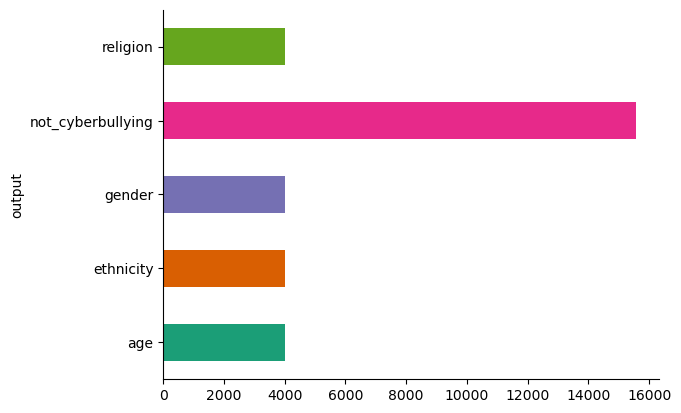

In [8]:

from matplotlib import pyplot as plt
import seaborn as sns
dataset.groupby('output').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31550 entries, 0 to 31549
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   feature  31550 non-null  object
 1   output   31550 non-null  object
dtypes: object(2)
memory usage: 493.1+ KB


In [10]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [11]:
ps = PorterStemmer()

In [9]:
import re
def clean_text(y):
    # Remove HTML tags
    x = re.sub(r'@\S+','',y)
    x_ = re.sub(r'http\S+','',x)
    x__ = re.sub(r'#\S+','',x_)
    text = re.sub('<.*?>', '', x__)
    text = re.sub('[^a-zA-Z]', ' ', text).lower()
    return text

In [10]:
corpus = []


for i in range(0, 47998):
    twitter = clean_text(dataset['feature'][i])
    twitter = twitter.split()
    new_twitter = [ps.stem(word) for word in twitter if not word in set(stopwords.words('english'))]
    new_twitter = ' '.join(new_twitter)
    if i % 1000 == 0:
        print('|', end='')
    corpus.append(new_twitter)

||||||||||||||||||||||||||||||||||||||||||||||||

After preprocessing the dataset we created a new preprocessed dataset which we used for the training part.

In [12]:
corpus = dataset['feature']

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features = 8000, min_df = 3, max_df = 0.6)


In [14]:
x = vectorizer.fit_transform(corpus).toarray()

In [15]:
x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
label_mapping = {"age": 0, "ethnicity": 1, "not_cyberbullying": 2,"religion": 3, "gender": 4}
dataset['label'] = dataset['output'].replace(label_mapping)

In [17]:
y = dataset['label']

In [18]:
y = y.to_numpy()

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.15, random_state = 42)


## Neural Network

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F


In [21]:

if torch.cuda.is_available():
    print("GPU is available!")
    device = torch.device("cuda")
else:
    print("GPU is not available. Training will be on CPU.")
    device = torch.device("cpu")

GPU is available!


In [31]:
Xtrain_ = torch.from_numpy(X_train).float().to(device)
Xtest_ = torch.from_numpy(X_test).float().to(device)

ytrain_ = torch.from_numpy(y_train).to(device)
ytest_ = torch.from_numpy(y_test).to(device)

In [23]:
input_size = 7822
output_size = 5
hidden_size = 500

In [42]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear (hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, X):
        X = torch.relu((self.fc1(X)))
        X = torch.relu((self.fc2(X)))
        X = self.fc3(X)

        return F.log_softmax(X, dim = 1)

model = Net()


In [43]:
model.to(device)

Net(
  (fc1): Linear(in_features=7822, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=5, bias=True)
)

In [44]:
import torch.optim as optim
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

loss_fn = nn.NLLLoss()

In [45]:
epochs = 100
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()
    Ypred = model(Xtrain_)
    loss = loss_fn(Ypred, ytrain_)
    loss.backward()
    optimizer.step()
    print('Epoch:', epoch, 'Loss:', loss.item())

Epoch: 0 Loss: 1.6220364570617676
Epoch: 1 Loss: 1.466265320777893
Epoch: 2 Loss: 1.346131682395935
Epoch: 3 Loss: 1.2145572900772095
Epoch: 4 Loss: 1.129787802696228
Epoch: 5 Loss: 1.0442206859588623
Epoch: 6 Loss: 0.9811609387397766
Epoch: 7 Loss: 0.907472550868988
Epoch: 8 Loss: 0.8184772729873657
Epoch: 9 Loss: 0.7074112296104431
Epoch: 10 Loss: 0.5647177696228027
Epoch: 11 Loss: 0.41136977076530457
Epoch: 12 Loss: 0.28245240449905396
Epoch: 13 Loss: 0.20461690425872803
Epoch: 14 Loss: 0.15565750002861023
Epoch: 15 Loss: 0.12509754300117493
Epoch: 16 Loss: 0.10010889172554016
Epoch: 17 Loss: 0.08710512518882751
Epoch: 18 Loss: 0.07065203040838242
Epoch: 19 Loss: 0.06324125826358795
Epoch: 20 Loss: 0.051779549568891525
Epoch: 21 Loss: 0.045465175062417984
Epoch: 22 Loss: 0.03857233747839928
Epoch: 23 Loss: 0.032405730336904526
Epoch: 24 Loss: 0.029148243367671967
Epoch: 25 Loss: 0.023599809035658836
Epoch: 26 Loss: 0.021873420104384422
Epoch: 27 Loss: 0.018683139234781265
Epoch: 28 

In [46]:
ypred = model(Xtest_)


In [47]:
ypred_ = ypred.cpu().detach().numpy()

In [48]:
def foo(i):
    inv_label = {
        0 :"age",
        1: "ethnicity",
        2: "not cyberbullying",
        3: "religion",
        4: "gender"
    }
    max_value = np.max(i)
    max_index = np.argmax(i)
    return max_index

In [37]:
newoutput = []

for i in ypred_:
    newoutput.append(foo(i))

In [38]:
finalpred = np.array(newoutput)

In [39]:
from sklearn.metrics import classification_report
report = classification_report(y_test, finalpred)
print(report)

              precision    recall  f1-score   support

           0       0.82      0.78      0.80       632
           1       0.88      0.83      0.86       607
           2       0.84      0.85      0.84      2294
           3       0.78      0.83      0.80       588
           4       0.72      0.70      0.71       612

    accuracy                           0.82      4733
   macro avg       0.81      0.80      0.80      4733
weighted avg       0.82      0.82      0.82      4733



## Logistic Regression

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# train a Logistic Regression Model


In [56]:
clf = LogisticRegression(max_iter = 1000)

In [58]:
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [59]:
y_pred = clf.predict(X_test)

In [60]:

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       632
           1       0.98      0.95      0.96       607
           2       0.87      0.95      0.91      2294
           3       0.95      0.90      0.92       588
           4       0.92      0.73      0.81       612

    accuracy                           0.91      4733
   macro avg       0.93      0.88      0.90      4733
weighted avg       0.91      0.91      0.91      4733



## Naive Bayes

In [61]:
NB = MultinomialNB(alpha = 0.1, fit_prior = True)
NB.fit(X_train, y_train)



MultinomialNB(alpha=0.1)

In [62]:
NB_pred = NB.predict(X_test)

In [63]:
report = classification_report(y_test, NB_pred)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.73      0.79       632
           1       0.88      0.83      0.85       607
           2       0.81      0.89      0.85      2294
           3       0.82      0.89      0.85       588
           4       0.86      0.64      0.73       612

    accuracy                           0.83      4733
   macro avg       0.85      0.79      0.82      4733
weighted avg       0.83      0.83      0.83      4733



## K- Nearest Neighbour

In [76]:
KNN= KNeighborsClassifier(n_neighbors=4500, metric='euclidean', weights = 'distance')  
KNN.fit(X_train, y_train)  

KNeighborsClassifier(metric='euclidean', n_neighbors=4500, weights='distance')

In [77]:
KNN_pred = KNN.predict(X_test)

In [78]:
report = classification_report(y_test, KNN_pred)
print(report)

              precision    recall  f1-score   support

           0       0.73      0.94      0.82       632
           1       0.84      0.72      0.78       607
           2       0.73      0.87      0.79      2294
           3       0.93      0.52      0.67       588
           4       0.93      0.52      0.67       612

    accuracy                           0.77      4733
   macro avg       0.83      0.71      0.75      4733
weighted avg       0.80      0.77      0.76      4733

